In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [13]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
results = session.query(measurement.date).\
    order_by(measurement.date.desc()).all()
dates = [i for i, in results]
one_year_ago = dt.datetime.strptime(dates[0], "%Y-%m-%d") - dt.timedelta(days=365)
one_year_ago = dt.datetime.strftime(one_year_ago, "%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.date <= dates[0])

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(results, columns=['date', 'prcp'])
df['date'] = pd.to_datetime(df["date"], format='%Y-%m-%d', errors='coerce')
df = df.sort_values("date")
df = df.set_index("date")

In [159]:
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


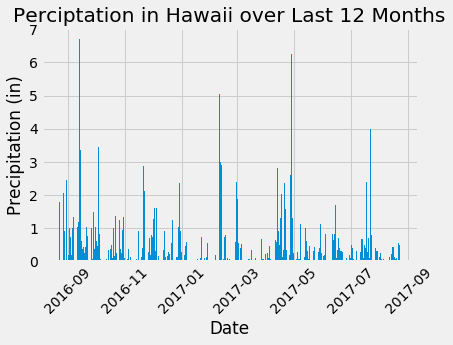

In [177]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.bar(df.index.get_values(), df["prcp"], align="center")
ax.xaxis_date()
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Precipitation (in)")
plt.title("Perciptation in Hawaii over Last 12 Months")
plt.show()

In [178]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [181]:
# Design a query to show how many stations are available in this dataset?
session.query(measurement.station).distinct().count()

9

In [206]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(measurement.station, measurement.tobs)

station_count_df = pd.DataFrame(results, columns = ["station", "tobs"])
station_count_df["station"].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [209]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = station_count_df["station"].mode()[0]
most_active_df = station_count_df[station_count_df["station"] == most_active]
min_temp = most_active_df["tobs"].min()
max_temp = most_active_df["tobs"].max()
avg_temp = most_active_df["tobs"].mean()

print(f"For station {most_active}, the minimum temperature recorded was {min_temp}, the maximum was {max_temp}, and the average is {round(avg_temp, 2)}")

For station USC00519281, the minimum temperature recorded was 54.0, the maximum was 85.0, and the average is 71.66


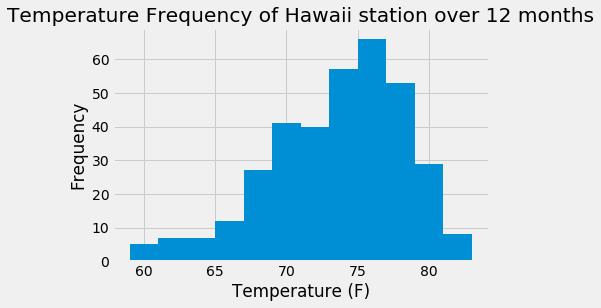

In [227]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.date <= dates[0]).\
    filter(measurement.station == most_active)
most_active_year_df = pd.DataFrame(results, columns=["station", "tobs"])

plt.hist(most_active_year_df["tobs"], bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency of Hawaii station over 12 months")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
